In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from variational_auto_encoder import VariationalAutoEncoder
from stacked_mnist import StackedMNISTData, DataMode
import numpy as np
import matplotlib.pyplot as plt
from verification_net import VerificationNet
import tensorflow_probability as tfp

In [3]:
variational_auto_encoder = VariationalAutoEncoder(latent_dim=8)
variational_auto_encoder.model.summary()
variational_auto_encoder.train(force_relearn=True)

2022-03-03 22:27:01.727163: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 22:27:01.856234: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 40)                92200     
                                                                 
 independent_normal (Indepen  ((None, 20),             0         
 dentNormal)                  (None, 20))                        
                                                             

# Mono Images

In [4]:
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)

### Reconstruction results

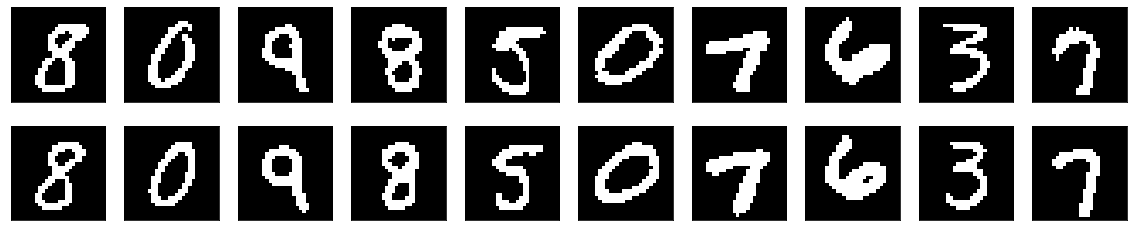

In [15]:
reconstructed = variational_auto_encoder.reconstruct(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(reconstructed[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
net = VerificationNet(force_learn=False, file_name="../models/verification_model")
_, acc_ae = net.check_predictability(data=reconstructed, correct_labels=y_test)
print(f"Accuracy of Reconstruction: {100 * acc_ae:.2f}%")


/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy of Reconstruction: 83.20%


### Autoencoder as a generator

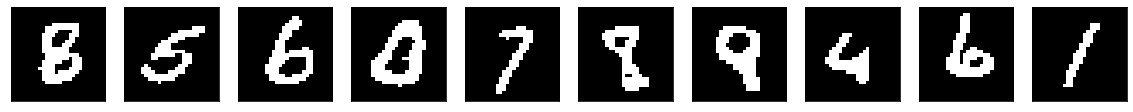

In [17]:
generated = variational_auto_encoder.generate_new_samples()
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(generated[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
cov = net.check_class_coverage(data=generated, tolerance=0.98)
pred, _ = net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 100.00%
Predictability: 74.00%


# Color Images

In [19]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)
x_test = x_test.astype(np.float64)

### Reconstruction results

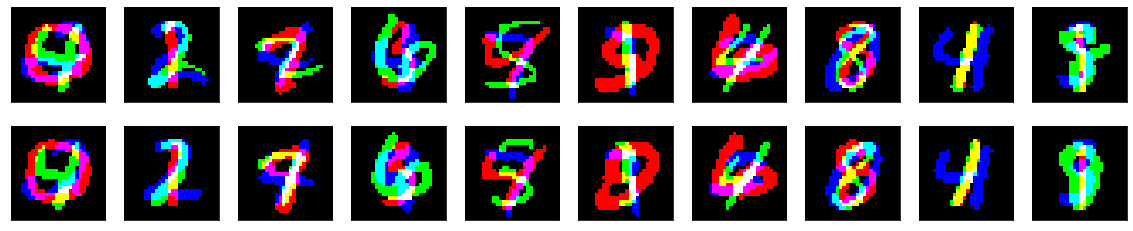

In [20]:
reconstructed = variational_auto_encoder.reconstruct(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(reconstructed[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [21]:
net = VerificationNet(force_learn=False, file_name="../models/verification_model")
_, acc_ae = net.check_predictability(data=reconstructed, correct_labels=y_test)
print(f"Accuracy of Reconstruction: {100 * acc_ae:.2f}%")

Accuracy of Reconstruction: 59.35%


### Variational-Auto-Encoder as a generator

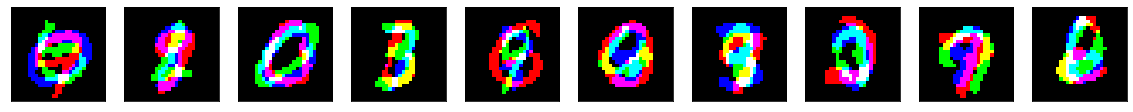

In [22]:
generated = variational_auto_encoder.generate_new_samples(no_channels=3)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(generated[i-1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [23]:
cov = net.check_class_coverage(data=generated, tolerance=0.98)
pred, _ = net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 10.60%
Predictability: 39.90%


# Variational-Auto-Encoder as anomaly detector

In [25]:
vae_anomaly = VariationalAutoEncoder(latent_dim=8, missing=True)
vae_anomaly.train(force_relearn=True)

Epoch 1/10
424/424 [==============================] - 33s 73ms/step - loss: 204.9369 - val_loss: 162.3408
Epoch 2/10
158/424 [==========>...................] - ETA: 17s - loss: 153.7307

### Mono images

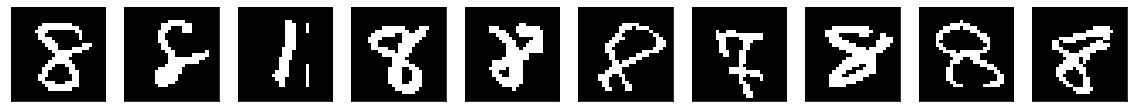

In [ ]:
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)

anomalies = vae_anomaly.get_anomalies(x_test)
 
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[anomalies[i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Color images

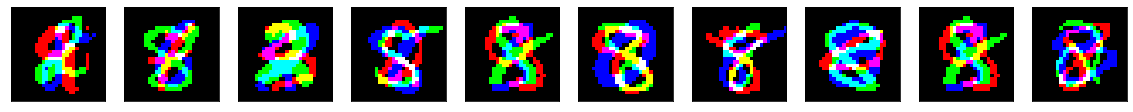

In [ ]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)
x_test = x_test.astype(np.float64)

anomalies = vae_anomaly.get_anomalies(x_test)
 
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[anomalies[i-1]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()